In [21]:
import cv2
import os

# Input & Output Folders
input_folder = "anime_images"  # Folder with your downloaded images
output_folder = "sketch_images"  # Folder for sketches
os.makedirs(output_folder, exist_ok=True)

def convert_to_sketch(image_path, output_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
    img_inverted = cv2.bitwise_not(img)  # Invert colors
    img_blurred = cv2.GaussianBlur(img_inverted, (21, 21), sigmaX=0, sigmaY=0)  # Apply Gaussian blur
    img_sketch = cv2.divide(img, 255 - img_blurred, scale=256)  # Blend original with blurred
    cv2.imwrite(output_path, img_sketch)  # Save the sketch

# Convert all images
for img_file in os.listdir(input_folder):
    img_path = os.path.join(input_folder, img_file)
    sketch_path = os.path.join(output_folder, img_file)
    convert_to_sketch(img_path, sketch_path)

print("Sketch conversion complete! ✅")

Sketch conversion complete! ✅


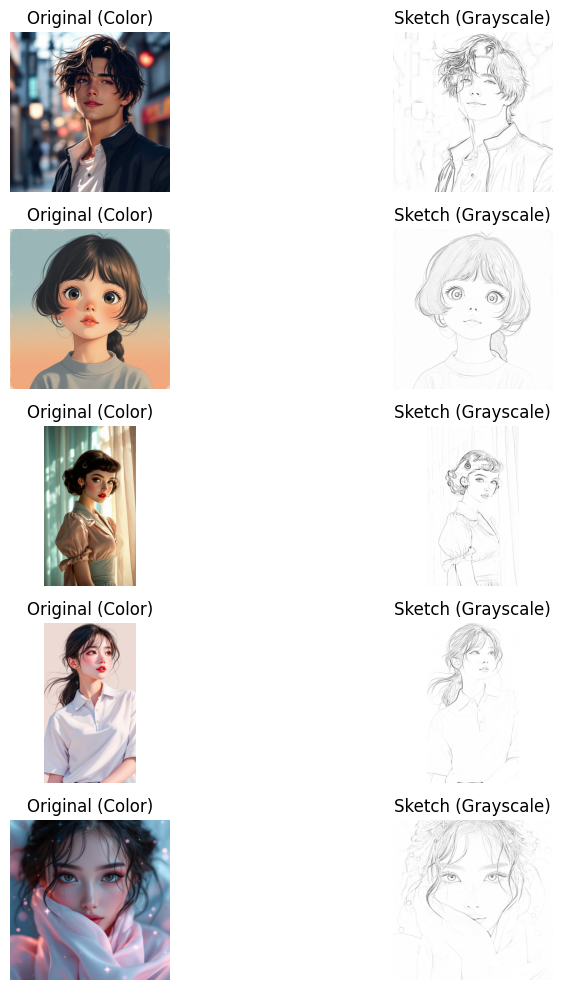

In [44]:
import cv2
import os
import matplotlib.pyplot as plt

# Define dataset paths
original_folder = "dataset/train/original"
sketch_folder = "dataset/train/sketch"

# Get a sample of images
sample_files = os.listdir(original_folder)[3:8]

# Check if there are images
if len(sample_files) == 0:
    print("No images found in the dataset. Please check the folder path.")
else:
    # Plot the images
    fig, axes = plt.subplots(len(sample_files), 2, figsize=(10, 10))

    for idx, img_file in enumerate(sample_files):
        original_path = os.path.join(original_folder, img_file)
        sketch_path = os.path.join(sketch_folder, img_file)

        # Read original image in COLOR
        original = cv2.imread(original_path)
        original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct color display

        # Read sketch in GRAYSCALE
        sketch = cv2.imread(sketch_path, cv2.IMREAD_GRAYSCALE)

        # Plot original image
        axes[idx, 0].imshow(original)
        axes[idx, 0].set_title("Original (Color)")
        axes[idx, 0].axis("off")

        # Plot sketch
        axes[idx, 1].imshow(sketch, cmap="gray")
        axes[idx, 1].set_title("Sketch (Grayscale)")
        axes[idx, 1].axis("off")

    plt.tight_layout()
    plt.show()

In [23]:
import shutil

# Create directories
os.makedirs("dataset/train/original", exist_ok=True)
os.makedirs("dataset/train/sketch", exist_ok=True)

# Move files
for img_file in os.listdir(input_folder):
    shutil.move(os.path.join(input_folder, img_file), "dataset/train/original")

for sketch_file in os.listdir(output_folder):
    shutil.move(os.path.join(output_folder, sketch_file), "dataset/train/sketch")

print("Dataset organized for Pix2Pix! ✅")

Dataset organized for Pix2Pix! ✅


In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image
import matplotlib.pyplot as plt

In [25]:
# -----------------
# Generator (U-Net)
# -----------------
class UNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, activation='relu', dropout=False):
        super().__init__()
        self.down = down
        self.activation = activation
        self.dropout = dropout

        if down:
            self.conv = nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1, bias=False)
            self.norm = nn.BatchNorm2d(out_channels)
        else:
            self.conv = nn.ConvTranspose2d(in_channels, out_channels, 4, stride=2, padding=1, bias=False)
            self.norm = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        x = F.leaky_relu(x, 0.2) if self.activation == 'leaky' else F.relu(x)
        if self.dropout:
            x = F.dropout(x, 0.5, training=True)
        return x


class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.ModuleList([
            UNetBlock(1, 64, down=True, activation='leaky'),
            UNetBlock(64, 128, down=True),
            UNetBlock(128, 256, down=True),
            UNetBlock(256, 512, down=True),
            UNetBlock(512, 512, down=True),
            UNetBlock(512, 512, down=True),
        ])
        self.decoder = nn.ModuleList([
            UNetBlock(512, 512, down=False, dropout=True),
            UNetBlock(1024, 512, down=False, dropout=True),
            UNetBlock(1024, 256, down=False),
            UNetBlock(512, 128, down=False),
            UNetBlock(256, 64, down=False),
            nn.ConvTranspose2d(128, 3, 4, stride=2, padding=1, bias=False),
        ])

    def forward(self, x):
        skips = []
        for layer in self.encoder:
            x = layer(x)
            skips.append(x)
        skips = skips[:-1][::-1]

        for i, layer in enumerate(self.decoder[:-1]):
            x = layer(x)
            x = torch.cat((x, skips[i]), dim=1)
        x = self.decoder[-1](x)
        return torch.tanh(x)

In [26]:
# ---------------------
# Discriminator (PatchGAN)
# ---------------------
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            UNetBlock(4, 64, down=True, activation='leaky'),
            UNetBlock(64, 128, down=True, activation='leaky'),
            UNetBlock(128, 256, down=True, activation='leaky'),
            nn.Conv2d(256, 1, 4, stride=1, padding=1, bias=False)
        )

    def forward(self, x, y):
        x = torch.cat((x, y), dim=1)
        return self.model(x)

In [27]:
# ---------------------
# Dataset Preparation
# ---------------------
class Pix2PixDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_files = os.listdir(os.path.join(root, "original"))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.root, "original", img_name)
        sketch_path = os.path.join(self.root, "sketch", img_name)

        img = Image.open(img_path).convert("RGB")
        sketch = Image.open(sketch_path).convert("L")

        if self.transform:
            img = self.transform(img)
            sketch = self.transform(sketch)

        return sketch, img

In [28]:
# ---------------------
# Training Configuration
# ---------------------
def train_pix2pix():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    dataset = Pix2PixDataset("dataset/train", transform=transform)
    dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

    G = Generator().to(device)
    D = Discriminator().to(device)

    criterion_GAN = nn.BCEWithLogitsLoss()
    criterion_L1 = nn.L1Loss()
    optimizer_G = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

    for epoch in range(80):
        for sketch, real in dataloader:
            sketch, real = sketch.to(device), real.to(device)
            fake = G(sketch)

            # Train Discriminator
            D_real = D(sketch, real)
            D_fake = D(sketch, fake.detach())
            loss_D = criterion_GAN(D_real, torch.ones_like(D_real)) + criterion_GAN(D_fake, torch.zeros_like(D_fake))
            optimizer_D.zero_grad()
            loss_D.backward()
            optimizer_D.step()

            # Train Generator
            G_fake = D(sketch, fake)
            loss_G = criterion_GAN(G_fake, torch.ones_like(G_fake)) + criterion_L1(fake, real) * 100
            optimizer_G.zero_grad()
            loss_G.backward()
            optimizer_G.step()

        print(f"Epoch {epoch+1}, Loss D: {loss_D.item()}, Loss G: {loss_G.item()}")

    torch.save(G.state_dict(), "generator.pth")
    print("Training complete! Model saved.")

In [29]:
train_pix2pix()

Epoch 1, Loss D: 1.012295126914978, Loss G: 54.49641418457031
Epoch 2, Loss D: 0.8455318212509155, Loss G: 60.338253021240234
Epoch 3, Loss D: 0.6620450019836426, Loss G: 42.60697555541992
Epoch 4, Loss D: 0.5799063444137573, Loss G: 43.24512481689453
Epoch 5, Loss D: 0.4924355149269104, Loss G: 52.17572784423828
Epoch 6, Loss D: 0.4152028262615204, Loss G: 48.80152130126953
Epoch 7, Loss D: 0.16678449511528015, Loss G: 55.81871032714844
Epoch 8, Loss D: 0.3419147729873657, Loss G: 48.42373275756836
Epoch 9, Loss D: 0.15055251121520996, Loss G: 57.22140121459961
Epoch 10, Loss D: 0.350024551153183, Loss G: 50.88508224487305
Epoch 11, Loss D: 0.8532378077507019, Loss G: 39.561920166015625
Epoch 12, Loss D: 0.8139522075653076, Loss G: 56.64509963989258
Epoch 13, Loss D: 0.19384697079658508, Loss G: 55.932151794433594
Epoch 14, Loss D: 0.32810187339782715, Loss G: 50.65183639526367
Epoch 15, Loss D: 0.6297221183776855, Loss G: 46.99341583251953
Epoch 16, Loss D: 1.5017741918563843, Loss G

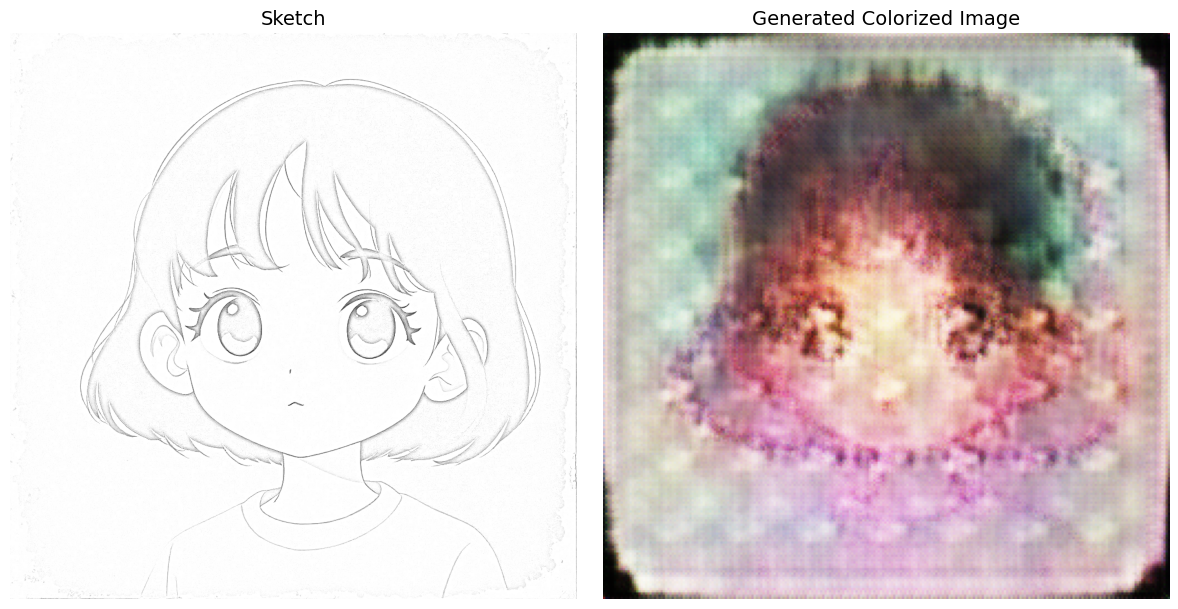

In [45]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms



def test_single_image(image_path):
    """ Convert image to sketch, generate colorized version, and visualize both """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load Generator model
    G = Generator().to(device)
    G.load_state_dict(torch.load("generator.pth", map_location=device))
    G.eval()

    # Convert image to sketch
    sketch = convert_to_sketch(image_path)

    # Apply transformations for model input
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Convert sketch to PIL image, then to tensor
    sketch_pil = Image.fromarray(sketch)  # Convert NumPy array to PIL
    sketch_tensor = transform(sketch_pil).unsqueeze(0).to(device)  # Add batch dimension

    # Generate colorized image
    with torch.no_grad():
        fake = G(sketch_tensor).cpu().squeeze(0).permute(1, 2, 0)  # Convert to (H, W, C)
        fake = (fake * 0.5 + 0.5).clamp(0, 1).numpy()  # Normalize to [0,1] range

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(sketch, cmap="gray")
    axes[0].set_title("Sketch", fontsize=14)
    axes[0].axis("off")

    axes[1].imshow(fake)
    axes[1].set_title("Generated Colorized Image", fontsize=14)
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

# Call function with an original image
test_single_image("/content/test5.jpg")